In [1]:
import os

import numpy as np #데이터 처리
import pandas as pd #데이터 처리
import warnings
warnings.filterwarnings('ignore')
from collections import Counter # count 용도

import matplotlib.pyplot as plt # 시각화
import seaborn as sns #시각화

import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

import random #데이터 샘플링
from sklearn.model_selection import GridSearchCV #모델링
from sklearn.ensemble import RandomForestRegressor #모델링
path = "/content/drive/MyDrive/YBIGTA/21-1 겨울방학/Jupyter Temp/프로젝트/"
pd.set_option("display.max_rows",None)

In [2]:
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

# 1. date 변수 변환


In [3]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [4]:
train["date"] = pd.to_datetime(train['date'])
train['weekday'] = train['date'].dt.weekday

In [5]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6


In [6]:
test['date'] = pd.to_datetime(test['date'])
test['weekday'] = test['date'].dt.weekday

In [7]:
train.groupby(by="weekday")["18~20_ride"].sum()

weekday
0    104073.0
1     87220.0
2     88404.0
3     74122.0
4     59451.0
5     48419.0
6     54306.0
Name: 18~20_ride, dtype: float64

# 2. in_out 변수 변환


In [8]:
train['in_out'].value_counts()

시내    408500
시외      6923
Name: in_out, dtype: int64

In [9]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

# 3. 변수간 상관관계 확인

In [10]:
cor=train.corr()

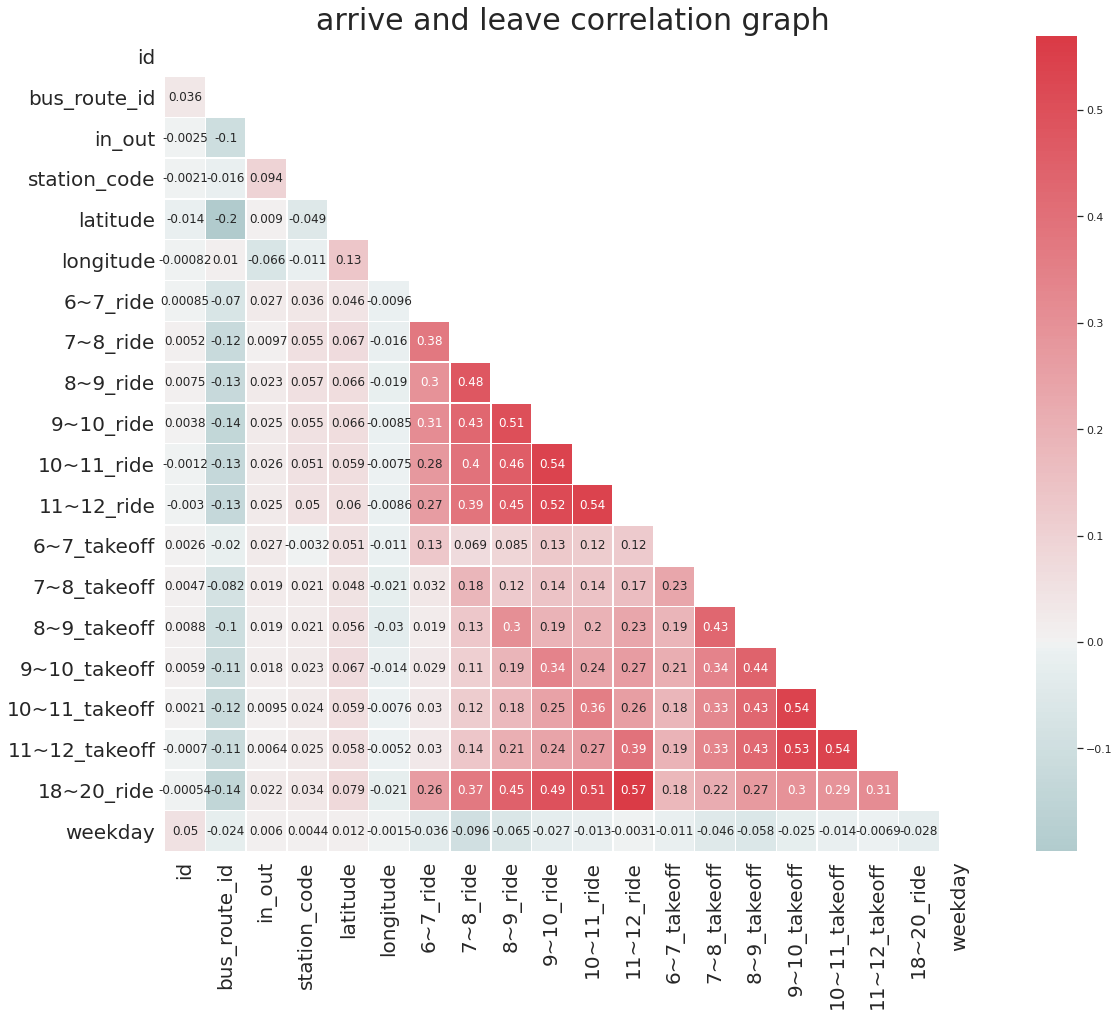

In [11]:
sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

# 4. 좌표 데이터를 이용한 Feature Engineering
## 4-1. 측정소 위치 및 정류장 위치 확인

In [12]:
area = pd.read_excel(path + "행정_법정동 중심좌표.xlsx")

In [13]:
area.head()

,코드,시도,시군구,읍면동,하위,위도,경도,코드종류
0,1111051500,서울특별시,종로구,청운효자동,NaN,37.584009,126.970626,H
1,1111053000,서울특별시,종로구,사직동,NaN,37.575408,126.965944,H
2,1111054000,서울특별시,종로구,삼청동,NaN,37.590758,126.980996,H
3,1111055000,서울특별시,종로구,부암동,NaN,37.594768,126.965574,H
4,1111056000,서울특별시,종로구,평창동,NaN,37.613029,126.974485,H


In [14]:
area = area.drop(["코드","하위","코드종류"],axis=1)
area = area[area["시도"]=="제주특별자치도"]
area = area.groupby(by = ["시군구","읍면동"]).median().reset_index()
area["lat_lon"] = list(zip( area['위도'],area['경도'] ))
area 

,시군구,읍면동,위도,경도,lat_lon
0,서귀포시,강정동,33.248323,126.491240,"(33.248323, 126.49124)"
1,서귀포시,남원읍,33.298845,126.700156,"(33.2988445, 126.70015649999999)"
2,서귀포시,대륜동,33.248173,126.511445,"(33.248173, 126.511445)"
3,서귀포시,대정읍,33.256852,126.255028,"(33.2568515, 126.255028)"
4,서귀포시,대천동,33.250783,126.477610,"(33.250783, 126.47761000000001)"
5,서귀포시,대포동,33.247863,126.437408,"(33.247863, 126.437408)"
6,서귀포시,도순동,33.254758,126.473867,"(33.254758, 126.473867)"
7,서귀포시,동홍동,33.277568,126.560684,"(33.277568, 126.5606845)"
8,서귀포시,법환동,33.240371,126.512796,"(33.240371, 126.512796)"
9,서귀포시,보목동,33.243637,126.600829,"(33.243637, 126.600829)"


## 4-2. 측정소와 정류장 사이 거리 계산 적용


In [15]:
def nearest(lat,lon):
  near = ["시군구","읍면동",100000000000]
  for i in range(len(area)):
    areaCenter = area["lat_lon"][i]
    distance = np.sqrt((lat-areaCenter[0])**2 + (lon-areaCenter[1])**2)
    if distance < near[2]:
      near = [area["시군구"][i], area["읍면동"][i],distance]
  return near[:2]

In [16]:
station_ll = train.groupby(by="station_code")[["latitude","longitude"]].mean().reset_index() 

In [17]:
station_ll = station_ll.merge(test.groupby(by="station_code")[["latitude","longitude"]].mean().reset_index(),
                              how="outer")
station_ll = station_ll.groupby("station_code").mean().reset_index()
station_ll

,station_code,latitude,longitude
0,0,33.486549,126.499152
1,1,33.524380,126.544330
2,2,33.495270,126.456180
3,3,33.495460,126.456230
4,4,33.494880,126.461370
5,5,33.495080,126.461220
6,6,33.490600,126.473930
7,7,33.490680,126.474180
8,8,33.488430,126.476780
9,9,33.487650,126.477260


In [18]:
station_ll["lat_lon"] = list(zip(station_ll["latitude"],station_ll["longitude"]))
station_ll["시군구"] = station_ll["lat_lon"].apply(lambda x : nearest(x[0],x[1])[0] )
station_ll["읍면동"] = station_ll["lat_lon"].apply(lambda x : nearest(x[0],x[1])[1] )

In [19]:
sgg_dict = dict(zip(station_ll["station_code"],station_ll["시군구"]))
ymd_dict = dict(zip(station_ll["station_code"],station_ll["읍면동"]))

In [20]:
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [21]:
train["시군구"] = train["station_code"].apply(lambda x: sgg_dict[x])
train["읍면동"] = train["station_code"].apply(lambda x: ymd_dict[x])

test["시군구"] = test["station_code"].apply(lambda x: sgg_dict[x])
test["읍면동"] = test["station_code"].apply(lambda x: ymd_dict[x])

In [22]:
test.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,weekday,시군구,읍면동
0,415423,2019-10-01,4270000,1,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,제주시,도두이동
1,415424,2019-10-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1,제주시,도두이동
2,415425,2019-10-01,4270000,1,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,제주시,이호이동
3,415426,2019-10-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1,제주시,용담2동
4,415427,2019-10-01,4270000,0,1636,롯데호텔,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,서귀포시,예래동


In [23]:
train["읍면동"].unique()

array(['도두이동', '이호이동', '용담2동', '색달동', '예래동', '대포동', '상예동', '대천동', '송산동',
       '천지동', '안덕면', '월평동', '대륜동', '강정동', '법환동', '연동', '오라삼동', '오라일동',
       '서호동', '하원동', '추자면', '우도면', '조천읍', '삼양동', '삼양일동', '이도1동', '일도2동',
       '화북동', '구좌읍', '표선면', '성산읍', '중앙동', '남원읍', '외도동', '외도일동', '한림읍',
       '애월읍', '대정읍', '한경면', '회수동', '오라동', '아라일동', '이도이동', '이도2동', '아라이동',
       '도련일동', '해안동', '봉개동', '상효동', '호근동', '영천동', '도남동', '삼도1동', '일도일동',
       '용담1동', '건입동', '오라이동', '노형동', '오등동', '아라동', '도평동', '신효동', '서귀동',
       '효돈동', '하효동', '회천동', '일도이동', '용강동', '화북이동', '중문동', '영남동', '토평동',
       '도순동', '용담이동', '삼도2동', '삼도이동', '삼도일동', '이호일동', '내도동', '삼양이동',
       '삼양삼동', '화북일동', '일도1동', '이도일동', '도련이동', '외도이동', '도두일동', '영평동',
       '용담일동', '용담삼동', '이호동', '도두동', '보목동', '정방동', '동홍동', '하예동', '서홍동'],
      dtype=object)

# 5. 외부 실제 측정 데이터 활용


In [24]:
jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653)

In [25]:
wth_statioin = pd.DataFrame({"지역":["제주","고산","성산","서귀포"],"위도" : [33.51411,33.29382,33.38677,33.24616],"경도":[126.52969,126.16283,126.8802,126.5653]})

In [26]:
wth_statioin

,지역,위도,경도
0,제주,33.51411,126.52969
1,고산,33.29382,126.16283
2,성산,33.38677,126.88020
3,서귀포,33.24616,126.56530


In [27]:
def rain_nearest(lat,lon):
  near = ["지역",100000000000]
  for i in range(len(wth_statioin)):
    areaCenter = [wth_statioin.iloc[i,1],wth_statioin.iloc[i,2]]
    distance = np.sqrt((lat-areaCenter[0])**2 + (lon-areaCenter[1])**2)
    if distance < near[1]:
      near = [wth_statioin.iloc[i,0],distance]
  return near[0]

In [28]:
station_ll["weather_area"] = station_ll["lat_lon"].apply(lambda x : rain_nearest(x[0],x[1]))

In [29]:
station_ll

,station_code,latitude,longitude,lat_lon,시군구,읍면동,weather_area
0,0,33.486549,126.499152,"(33.486549, 126.499152)",제주시,오라삼동,제주
1,1,33.524380,126.544330,"(33.524379999999965, 126.54433000000012)",제주시,건입동,제주
2,2,33.495270,126.456180,"(33.49526999999999, 126.4561800000003)",제주시,이호일동,제주
3,3,33.495460,126.456230,"(33.49546000000006, 126.4562299999998)",제주시,이호일동,제주
4,4,33.494880,126.461370,"(33.494880000000144, 126.46137000000007)",제주시,이호이동,제주
5,5,33.495080,126.461220,"(33.49507999999993, 126.4612200000001)",제주시,이호이동,제주
6,6,33.490600,126.473930,"(33.49060000000006, 126.4739300000001)",제주시,도두일동,제주
7,7,33.490680,126.474180,"(33.49067999999991, 126.47417999999995)",제주시,도두일동,제주
8,8,33.488430,126.476780,"(33.48843000000003, 126.47677999999999)",제주시,도두이동,제주
9,9,33.487650,126.477260,"(33.48764999999989, 126.47725999999972)",제주시,도두이동,제주


In [30]:
wth_dict = dict(zip(station_ll["station_code"],station_ll["weather_area"]))

In [31]:
train["weather_area"] = train["station_code"].apply(lambda x: wth_dict[x])
test["weather_area"] = test["station_code"].apply(lambda x: wth_dict[x])

In [32]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,시군구,읍면동,weather_area
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,제주시,도두이동,제주
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6,제주시,도두이동,제주
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6,제주시,이호이동,제주
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6,제주시,용담2동,제주
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,서귀포시,색달동,서귀포


In [33]:
# https://data.kma.go.kr/cmmn/main.do
#데이터 불러오기
raining=pd.read_csv(path + "OBS_ASOS_TIM_20210114113345.csv",engine='python',encoding="cp949")

In [34]:
raining.head()

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2)
0,184,제주,2019-09-01 01:00,23.7,NaN,2.1,180.0,67,1013.8,1016.2,NaN,NaN
1,184,제주,2019-09-01 02:00,23.5,NaN,1.4,180.0,70,1013.7,1016.1,NaN,NaN
2,184,제주,2019-09-01 03:00,23.4,NaN,1.1,180.0,68,1013.8,1016.2,NaN,NaN
3,184,제주,2019-09-01 04:00,23.4,NaN,1.6,180.0,69,1013.6,1016.0,NaN,NaN
4,184,제주,2019-09-01 05:00,23.3,NaN,1.2,180.0,71,1013.6,1016.0,NaN,NaN


In [35]:
raining["지점명"].unique()

array(['제주', '고산', '성산', '서귀포'], dtype=object)

In [36]:
raining['time'] = [ int( i.split(' ')[1].split(':')[0] ) for i in raining['일시']] 
raining['일시'] = [ i.split(' ')[0] for i in raining['일시'] ] 

In [37]:
# 실제 측정 데이터이기 때문에, 12시 이전의 시간대만 사용
raining = raining[ (raining['time']>12) ]

In [38]:
raining = raining.groupby(['지점명','일시'])[['기온(°C)','강수량(mm)',"습도(%)","풍속(m/s)"]].mean().reset_index()

In [39]:
raining.head()

,지점명,일시,기온(°C),강수량(mm),습도(%),풍속(m/s)
0,고산,2019-09-01,22.018182,0.800000,90.727273,2.972727
1,고산,2019-09-02,26.145455,0.700000,95.545455,3.745455
2,고산,2019-09-03,25.254545,3.866667,98.272727,2.736364
3,고산,2019-09-04,24.463636,0.266667,91.636364,4.936364
4,고산,2019-09-05,27.136364,NaN,91.909091,4.690909


In [40]:
raining.rename(columns={"일시":"date","지점명":"weather_area"},inplace=True)
raining.fillna(method="bfill",inplace=True)

In [41]:
raining.head()

,weather_area,date,기온(°C),강수량(mm),습도(%),풍속(m/s)
0,고산,2019-09-01,22.018182,0.800000,90.727273,2.972727
1,고산,2019-09-02,26.145455,0.700000,95.545455,3.745455
2,고산,2019-09-03,25.254545,3.866667,98.272727,2.736364
3,고산,2019-09-04,24.463636,0.266667,91.636364,4.936364
4,고산,2019-09-05,27.136364,2.609091,91.909091,4.690909


In [42]:
raining["date"] = pd.to_datetime(raining["date"])

In [43]:
train=pd.merge(train,raining,how='left',on=['weather_area','date'])
test=pd.merge(test,raining,how='left',on=['weather_area','date'])

In [44]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,시군구,읍면동,weather_area,기온(°C),강수량(mm),습도(%),풍속(m/s)
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,제주시,도두이동,제주,22.727273,2.272727,89.363636,2.318182
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6,제주시,도두이동,제주,22.727273,2.272727,89.363636,2.318182
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6,제주시,이호이동,제주,22.727273,2.272727,89.363636,2.318182
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6,제주시,용담2동,제주,22.727273,2.272727,89.363636,2.318182
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,서귀포시,색달동,서귀포,22.127273,1.627273,98.454545,2.109091


In [45]:
train = pd.get_dummies(train,columns=['시군구'])
train = pd.get_dummies(train,columns=['읍면동'])
train = pd.get_dummies(train,columns=['weather_area'])

test = pd.get_dummies(test,columns=['시군구'])
test = pd.get_dummies(test,columns=['읍면동'])
test = pd.get_dummies(test,columns=['weather_area'])

In [46]:
train.shape, test.shape

((415423, 129), (228170, 128))

In [47]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,기온(°C),강수량(mm),습도(%),풍속(m/s),시군구_서귀포시,시군구_제주시,읍면동_강정동,읍면동_건입동,읍면동_구좌읍,읍면동_남원읍,읍면동_내도동,읍면동_노형동,읍면동_대륜동,읍면동_대정읍,읍면동_대천동,읍면동_대포동,읍면동_도남동,읍면동_도두동,...,읍면동_용담이동,읍면동_용담일동,읍면동_우도면,읍면동_월평동,읍면동_이도1동,읍면동_이도2동,읍면동_이도이동,읍면동_이도일동,읍면동_이호동,읍면동_이호이동,읍면동_이호일동,읍면동_일도1동,읍면동_일도2동,읍면동_일도이동,읍면동_일도일동,읍면동_정방동,읍면동_조천읍,읍면동_중문동,읍면동_중앙동,읍면동_천지동,읍면동_추자면,읍면동_토평동,읍면동_표선면,읍면동_하예동,읍면동_하원동,읍면동_하효동,읍면동_한경면,읍면동_한림읍,읍면동_해안동,읍면동_호근동,읍면동_화북동,읍면동_화북이동,읍면동_화북일동,읍면동_회수동,읍면동_회천동,읍면동_효돈동,weather_area_고산,weather_area_서귀포,weather_area_성산,weather_area_제주
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,22.727273,2.272727,89.363636,2.318182,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6,22.727273,2.272727,89.363636,2.318182,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6,22.727273,2.272727,89.363636,2.318182,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6,22.727273,2.272727,89.363636,2.318182,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,22.127273,1.627273,98.454545,2.109091,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [48]:
del train["id"]
del test["id"]

train["day"] = train["date"].apply(lambda x: x.day)
test["day"] = test["date"].apply(lambda x: x.day)

test["date"] = test["date"].apply(lambda x: str(x))
test["date"] = test["date"].apply(lambda x: x[:10])

display(test.head())

test.to_csv(path+"test_web.csv",index=False)

del train["date"]
del test["date"]

del train["station_code"]
del test["station_code"]

del train["station_name"]
del test["station_name"]

,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,weekday,기온(°C),강수량(mm),습도(%),풍속(m/s),시군구_서귀포시,시군구_제주시,읍면동_강정동,읍면동_건입동,읍면동_구좌읍,읍면동_남원읍,읍면동_내도동,읍면동_노형동,읍면동_대륜동,읍면동_대정읍,읍면동_대천동,읍면동_대포동,읍면동_도남동,읍면동_도두동,읍면동_도두이동,읍면동_도두일동,...,읍면동_용담일동,읍면동_우도면,읍면동_월평동,읍면동_이도1동,읍면동_이도2동,읍면동_이도이동,읍면동_이도일동,읍면동_이호동,읍면동_이호이동,읍면동_이호일동,읍면동_일도1동,읍면동_일도2동,읍면동_일도이동,읍면동_일도일동,읍면동_정방동,읍면동_조천읍,읍면동_중문동,읍면동_중앙동,읍면동_천지동,읍면동_추자면,읍면동_토평동,읍면동_표선면,읍면동_하예동,읍면동_하원동,읍면동_하효동,읍면동_한경면,읍면동_한림읍,읍면동_해안동,읍면동_호근동,읍면동_화북동,읍면동_화북이동,읍면동_화북일동,읍면동_회수동,읍면동_회천동,읍면동_효돈동,weather_area_고산,weather_area_서귀포,weather_area_성산,weather_area_제주,day
0,2019-10-01,4270000,1,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,23.009091,2.245455,91.727273,3.181818,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,2019-10-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1,23.009091,2.245455,91.727273,3.181818,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,2019-10-01,4270000,1,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,23.009091,2.245455,91.727273,3.181818,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,2019-10-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1,23.009091,2.245455,91.727273,3.181818,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,2019-10-01,4270000,0,1636,롯데호텔,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,22.518182,2.700000,99.000000,3.709091,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [ ]:
del train["id"]


# 6. randomforest을 활용한 모델링
## 6-1. 변수 선택 및 train data sampling


In [49]:
train.columns

Index(['bus_route_id', 'in_out', 'latitude', 'longitude', '6~7_ride',
       '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride',
       ...
       '읍면동_화북이동', '읍면동_화북일동', '읍면동_회수동', '읍면동_회천동', '읍면동_효돈동',
       'weather_area_고산', 'weather_area_서귀포', 'weather_area_성산',
       'weather_area_제주', 'day'],
      dtype='object', length=126)

In [51]:
X_train=train.drop(columns=["18~20_ride"])
y_train = train["18~20_ride"]

In [52]:
X_test=test

In [53]:
X_train.shape, y_train.shape

((415423, 125), (415423,))

In [54]:
X_test.shape

(228170, 125)

## 6-2. Neural Networks

In [55]:
X_train.head()

,bus_route_id,in_out,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,weekday,기온(°C),강수량(mm),습도(%),풍속(m/s),시군구_서귀포시,시군구_제주시,읍면동_강정동,읍면동_건입동,읍면동_구좌읍,읍면동_남원읍,읍면동_내도동,읍면동_노형동,읍면동_대륜동,읍면동_대정읍,읍면동_대천동,읍면동_대포동,읍면동_도남동,읍면동_도두동,읍면동_도두이동,읍면동_도두일동,읍면동_도련이동,읍면동_도련일동,읍면동_도순동,...,읍면동_용담일동,읍면동_우도면,읍면동_월평동,읍면동_이도1동,읍면동_이도2동,읍면동_이도이동,읍면동_이도일동,읍면동_이호동,읍면동_이호이동,읍면동_이호일동,읍면동_일도1동,읍면동_일도2동,읍면동_일도이동,읍면동_일도일동,읍면동_정방동,읍면동_조천읍,읍면동_중문동,읍면동_중앙동,읍면동_천지동,읍면동_추자면,읍면동_토평동,읍면동_표선면,읍면동_하예동,읍면동_하원동,읍면동_하효동,읍면동_한경면,읍면동_한림읍,읍면동_해안동,읍면동_호근동,읍면동_화북동,읍면동_화북이동,읍면동_화북일동,읍면동_회수동,읍면동_회천동,읍면동_효돈동,weather_area_고산,weather_area_서귀포,weather_area_성산,weather_area_제주,day
0,4270000,1,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6,22.727273,2.272727,89.363636,2.318182,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,4270000,1,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6,22.727273,2.272727,89.363636,2.318182,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,4270000,1,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,22.727273,2.272727,89.363636,2.318182,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,4270000,0,33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,6,22.727273,2.272727,89.363636,2.318182,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,4270000,0,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6,22.127273,1.627273,98.454545,2.109091,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [56]:
y_train.head()

0     0.0
1     5.0
2     2.0
3    53.0
4     0.0
Name: 18~20_ride, dtype: float64

In [57]:
X_train.shape

(415423, 125)

In [79]:
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold

In [87]:
from sklearn.model_selection import train_test_split


In [93]:
del X_train["day"]

In [111]:
X_train, X_test, y_train, y_test = train_test_split( X_train, y_train, test_size=0.2, random_state=42)

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.005,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 50,
    "num_leaves": 256,  
    "max_bin": 512,
    "num_iterations": 10000,
    "n_estimators": 1000
}

gbm = lgb.LGBMRegressor(**hyper_params)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will 

KeyboardInterrupt: ignored

In [112]:
import joblib
 #예측값 생성 후, test['18~20_ride']에 집어 넣는다.
gbm = LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
              importance_type='split', learning_rate=0.005, max_bin=512,
              max_depth=50, metric=['l2', 'auc'], min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
              n_jobs=-1, num_iterations=10000, num_leaves=256,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, task='train',
              verbose=0)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

joblib.dump(gbm, path + "lgbm.pkl")

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will 

['/content/drive/MyDrive/YBIGTA/21-1 겨울방학/Jupyter Temp/프로젝트/lgbm.pkl']

In [117]:
pred = np.expm1(gbm.predict(test))[0]
pred

19.363674995685138

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization


model = Sequential()


model.add(Dense(32,input_dim = 125))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation("softmax"))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(1))

In [64]:
model.compile(loss="mse",optimizer='rmsprop',metrics="acc")

In [67]:
model.fit(X_train, y_train, epochs=10,batch_size=512)

Epoch 1/10
812/812 [==============================] - 9s 11ms/step - loss: 20.0612 - acc: 0.3994
Epoch 2/10
812/812 [==============================] - 8s 10ms/step - loss: 20.5302 - acc: 0.3752
Epoch 3/10
812/812 [==============================] - 8s 10ms/step - loss: 20.4122 - acc: 0.3746
Epoch 4/10
812/812 [==============================] - 8s 10ms/step - loss: 19.6570 - acc: 0.3844
Epoch 5/10
812/812 [==============================] - 8s 9ms/step - loss: 20.6371 - acc: 0.3871
Epoch 6/10
812/812 [==============================] - 8s 9ms/step - loss: 19.8184 - acc: 0.3819
Epoch 7/10
812/812 [==============================] - 8s 9ms/step - loss: 20.5462 - acc: 0.3815
Epoch 8/10
812/812 [==============================] - 8s 10ms/step - loss: 20.5970 - acc: 0.3880
Epoch 9/10
812/812 [==============================] - 8s 10ms/step - loss: 20.2350 - acc: 0.3959
Epoch 10/10
812/812 [==============================] - 8s 10ms/step - loss: 19.7973 - acc: 0.3934


In [68]:
from keras.models import load_model
gbm.save(path+'model.h5')

In [106]:
del test["day"]

NotFittedError: ignored

In [ ]:
test['18~20_ride'] = model.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.

In [ ]:
test[['id','18~20_ride']].to_csv("/content/drive/MyDrive/YBIGTA/21-1 겨울방학/프로젝트/1. 버스 승차량 예측 프로젝트/DL/submission/submission_0115(2).csv",index=False)